In [1]:
# https://api.mongodb.com/python/current/tutorial.html
import pprint
from pymongo import MongoClient
import pandas as pd
import requests as req 
import json
import math
import re
import folium
from folium import plugins
import os
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
import seaborn as sns

api_key = os.environ["key"]   
g_key = os.environ["gkey"] 

client = MongoClient('mongodb://localhost:27017/')
db = client.ejercicio

In [2]:
# {$and:[{deadpooled_year:null}, {number_of_employees:{$ne:null}}, {"offices.latitude":{$ne:null}}, {"offices.latitude":{$exists:true}}]}

In [3]:
empresas= db.companhias.find({"$and":[{"deadpooled_year":None}, {"number_of_employees":{"$ne":None}},{"total_money_raised":{"$ne":None}}, {"offices.latitude":{"$ne":None}}, {"offices.latitude":{"$exists":"true"}}]})

In [4]:
df=pd.DataFrame(empresas)[["name","category_code","number_of_employees","founded_year", "total_money_raised","offices"]]

In [5]:
df1=df.copy()

In [6]:
res = req.get("https://api.exchangeratesapi.io/latest?base=USD").json()

In [7]:
def cambiar(string):
    if string.startswith("$"):
        string=string.replace("$","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= float(string)*1000000
        elif string.endswith("k"):
            string=string.replace("k","")
            string= float(string)*1000
        elif string.endswith("B"):
            string=string.replace("B","")
            string= float(string)*1000000000
        else:
            string=float(string)
    
    elif string.startswith("€"):
        string=string.replace("€","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= (float(string)*1000000)/res["rates"]["EUR"]
        elif string.endswith("k"):
            string=string.replace("k","")
            string= (float(string)*1000)/res["rates"]["EUR"]
        elif string.endswith("B"):
            string=string.replace("B","")
            string= (float(string)*1000000000)/res["rates"]["EUR"]
        else:
            string=float(string)
            
    elif string.startswith("£"):
        string=string.replace("£","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= (float(string)*1000000)/res["rates"]["GBP"]
        elif string.endswith("k"):
            string=string.replace("k","")
            string= (float(string)*1000)/res["rates"]["GBP"]
        elif string.endswith("B"):
            string=string.replace("B","")
            string= (float(string)*1000000000)/res["rates"]["GBP"]
        else:
            string=float(string)

    elif string.startswith("¥"):
        string=string.replace("¥","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= (float(string)*1000000)/res["rates"]["JPY"]
        elif string.endswith("k"):
            string=string.replace("k","")
            string= (float(string)*1000)/res["rates"]["JPY"]
        elif string.endswith("B"):
            string=string.replace("B","")
            string= (float(string)*1000000000)/res["rates"]["JPY"]
        else:
            string=float(string)
      
    elif string.startswith("C$"):
        string=string.replace("C$","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= (float(string)*1000000)/res["rates"]["CAD"]
        elif string.endswith("k"):
            string=string.replace("k","")
            string= (float(string)*1000)/res["rates"]["CAD"]
        elif string.endswith("B"):
            string=string.replace("B","")
            string= (float(string)*1000000000)/res["rates"]["CAD"]
        else:
            string=float(string)
            
    elif string.startswith("kr"):
        string=string.replace("kr","")
        if string.endswith("M"):
            string=string.replace("M","")
            string= (float(string)*1000000)/res["rates"]["SEK"]
        elif string.endswith("k"):
            string=string.replace("k","")
            string= (float(string)*1000)/res["rates"]["SEK"]
        elif string.endswith("B"):
            string=string.replace("B","")
            string= (float(string)*1000000000)/res["rates"]["SEK"]
        else:
            string=float(string)
        
    return string

In [8]:
lst=[]
for a in range(len(df1)):
    lst.append(df1["offices"][a][0]["city"])
df1["ciudad"]=lst

In [9]:
df1["total_money_raised"]=df1["total_money_raised"].apply(cambiar)

In [10]:
def getFirst(data):
    data = data['offices']
    principal = None
    if data[0]['latitude'] and data[0]['longitude']:
        principal = {
            "type":"Point",
            "coordinates":[data[0]['longitude'], data[0]['latitude']]}

    return {
        "totalOffices": len(data),
        "lat": data[0]['latitude'],
        "lng": data[0]['longitude'],
        "oficina_principal": principal}

In [11]:
first_office = df1[["offices"]].apply(getFirst, result_type="expand", axis=1)
df_clean = pd.concat([df1,first_office], axis=1)[["name","lng","lat", "oficina_principal","totalOffices", "category_code", "number_of_employees", "founded_year", "total_money_raised", "ciudad"]]
df_clean.to_json('limpio.json', orient="records")
df_clean.to_csv('limpio.csv')
oficinas=df_clean.copy()
oficinas=oficinas[(oficinas["total_money_raised"]>1000000) & (oficinas["founded_year"]>2005)]
lista_paises=list(oficinas.ciudad.value_counts().head(20).index)
df20=oficinas[oficinas["ciudad"].isin(lista_paises)]
df20.to_json('mirar.json', orient="records")
df20.head()

,name,lng,lat,oficina_principal,totalOffices,category_code,number_of_employees,founded_year,total_money_raised,ciudad
3,Scribd,-122.404052,37.789634,"{'type': 'Point', 'coordinates': [-122.404052,...",1,news,50,2007.0,2.580000e+07,San Francisco
5,Joost,-74.009447,40.746497,"{'type': 'Point', 'coordinates': [-74.0094471,...",1,games_video,0,2006.0,4.500000e+07,New York
6,Twitter,-122.416924,37.776805,"{'type': 'Point', 'coordinates': [-122.4169244...",1,social,1300,2006.0,1.160000e+09,San Francisco
10,Powerset,-122.395289,37.778613,"{'type': 'Point', 'coordinates': [-122.395289,...",1,search,60,2006.0,2.250000e+07,San Francisco
13,Kyte,-122.409173,37.788482,"{'type': 'Point', 'coordinates': [-122.409173,...",1,games_video,40,2006.0,2.340000e+07,San Francisco


In [13]:
ma = folium.Map([38, -97], zoom_start=4)
stationArr = df20[['lat', 'lng']].values
ma.add_child(plugins.HeatMap(stationArr, radius=15))
ma

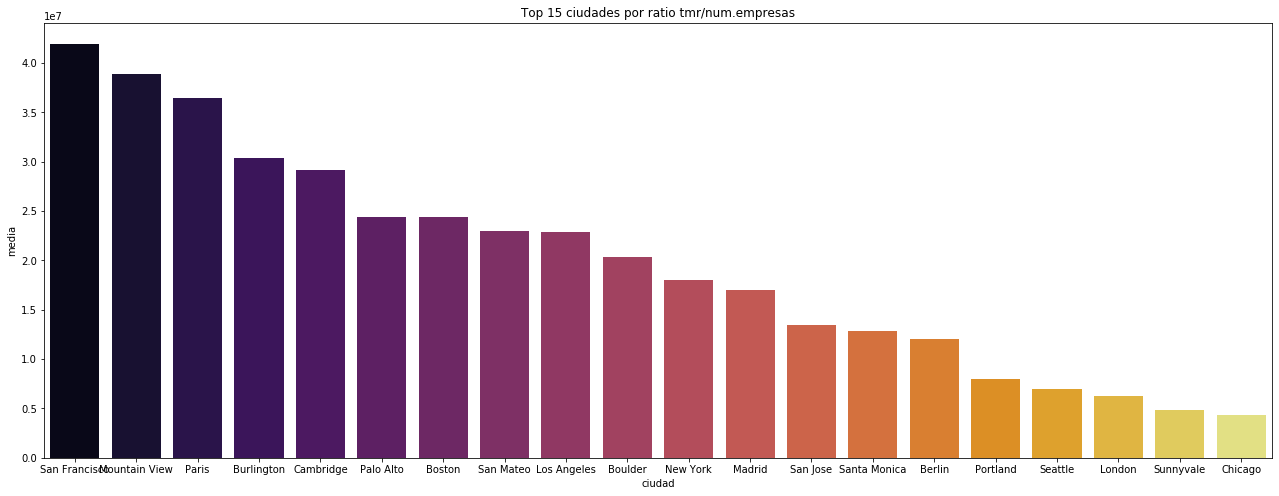

In [14]:
def calcMedia(c):
    bd = oficinas[oficinas["ciudad"]==c]
    contador=bd.ciudad.count()
    suma=bd.total_money_raised.sum()
    media=round(suma/contador)
    return media

res=[]
for c in lista_paises:
    a=calcMedia(c)
    res.append(a)
    
    
ciudad_media=pd.DataFrame()
ciudad_media["ciudad"]=lista_paises
ciudad_media["media"]=res
ciudad_media=ciudad_media.sort_values(["media"], ascending=False)


plt.subplots(figsize=(22,8))
sns.barplot(ciudad_media["ciudad"],ciudad_media["media"],palette='inferno')
plt.title('Top 15 ciudades por ratio tmr/num.empresas')
plt.show()

In [96]:
def find(ciu, metros,que):
    bd = df20[df20["ciudad"]==ciu]
    cd=[]
    for c in range(len(bd)):
        d={}
        coor=bd["oficina_principal"].values[c]['coordinates']
        query=db.limpio.find({"oficina_principal": {"$near": {"$geometry": {"type":"Point","coordinates":coor},"$maxDistance": metros,}}})
        num = query.count()
        coord=query[0]["oficina_principal"]["coordinates"]
        coordenada_buena=[coord[1],coord[0]]
        name=query[0]["name"]
        d.update(numero = num, donde = coordenada_buena, nombre = name)
        cd.append(d)
        nl = sorted(cd, key=lambda k: k['numero'], reverse=True)[0]
        
        res = req.get("https://maps.googleapis.com/maps/api/geocode/json?latlng={}, {}&key={}".format(nl["donde"][0], nl["donde"][1],g_key)).json()
        dirr= res["results"][1]["formatted_address"]
        places=req.get("https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input=spaces&inputtype=textquery&fields=formatted_address,name,geometry&locationbias=circle:500@{},{}&key={}".format(nl["donde"][0], nl["donde"][1],g_key)).json()
        lal=places["candidates"][0]["geometry"]["location"]["lat"]
        lol=places["candidates"][0]["geometry"]["location"]["lng"]
        cas=[lal, lol]
        lll_name= places["candidates"][0]["name"]
        
        start=req.get("https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input={}&inputtype=textquery&fields=formatted_address,name,geometry&locationbias=circle:200@{},{}&key={}".format(que,nl["donde"][0], nl["donde"][1],g_key)).json()
        slal=start["candidates"][0]["geometry"]["location"]["lat"]
        slol=start["candidates"][0]["geometry"]["location"]["lng"]
        scas=[slal, slol]
        
        
        #hacer mapa con folium
        mi = folium.Map(location=nl["donde"], zoom_start=15, control_scale=True)
        folium.Marker(location=nl["donde"], popup='{}: Hay {} empresas en un radio de {} metros'.format(dirr,nl["numero"],metros), icon=folium.Icon(color='blue', icon='home'),).add_to(mi)
        folium.Circle(location=nl["donde"], radius=nl["numero"]*30, color='blue', fill=True, fill_color='blue').add_to(mi)
        folium.Marker(location=cas, popup=lll_name, icon=folium.Icon(color='darkpurple', icon='home'),).add_to(mi)
        folium.Marker(location=scas, popup="{}".format(que), icon=folium.Icon(color='green', icon='home'),).add_to(mi)


        mi.save('index.html')
    return mi
    

In [97]:
find("San Francisco", 1000,"startbucks")

/usr/local/Cellar/ipython/7.3.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  
